In [17]:
import tp3
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd
from faker import Faker
import time
from joblib import dump, load


In [18]:
NAME_SIZE = 39
SUBSETS_SIZE = 200

In [19]:
#Library to ganerate ramdon team players 

def generate_fake_names():
    fake = Faker()
    random_names = set()
    random_names_list  = []
    while len(random_names) < NAME_SIZE:
        nombre = fake.name()
        random_names.add(nombre)

    random_names_list = list(random_names)
    return random_names, random_names_list

def generate_substsets(random_names):
    subsets = []
    for i in range(SUBSETS_SIZE): 
        subset = []
        for _ in range(i): 
            new_set = set()
            for k in range(random.randint(1, NAME_SIZE)):
                pos = random.randint(1, NAME_SIZE - 1)
                new_set.add(random_names[pos])
            subset.append(new_set)
        subsets.append(subset)
    return subsets


def calcular_tiempos(subsets, bt_func, lp_func, a):    
    time_list_bt = []  
    time_list_lp = []
    lengths = []    
    opts = []
    for i in range(len(subsets)):
        time_bt = 0
        time_lp = 0
        opt = 0
        for _ in range(5):
            bt_time_i = time.time()
            bt_sol = bt_func(subsets[i], a)
            bt_time_e = time.time()
            elapsed_time_bt = bt_time_e - bt_time_i

            lp_time_i = time.time()
            lp_sol = lp_func(subsets[i], a)
            lp_time_e = time.time()
            elapsed_time_lp = lp_time_e - lp_time_i
            
            if (len(bt_sol) != len(lp_sol)):
                continue
            time_bt += elapsed_time_bt
            time_lp += elapsed_time_lp
            opt = len(bt_sol)  
        if (time_bt == 0):
            continue
        time_list_bt.append(time_bt/5)
        time_list_lp.append(time_lp/5)
        lengths.append(len(subsets[i]))
        opts.append(opt)
    return time_list_bt, time_list_lp, lengths

In [20]:
fake_names, fake_name_list = generate_fake_names()
subsets = generate_substsets(fake_name_list)
dump(fake_names, "fake_names.plk")
dump(subsets, "subsets.plk")

['subsets.plk']

In [24]:
bt_time, lp_time, lengths, opts = calcular_tiempos(subsets, tp3.search_for_min_hitting_set, tp3.search_hs_linealp, fake_names)
times = pd.DataFrame({'m': lengths, 'bt_time': bt_time, 'ilp_time': lp_time})
times.to_csv('times.csv', index=False)

Text(0.5, 0, 'Cantidad de conjuntos')

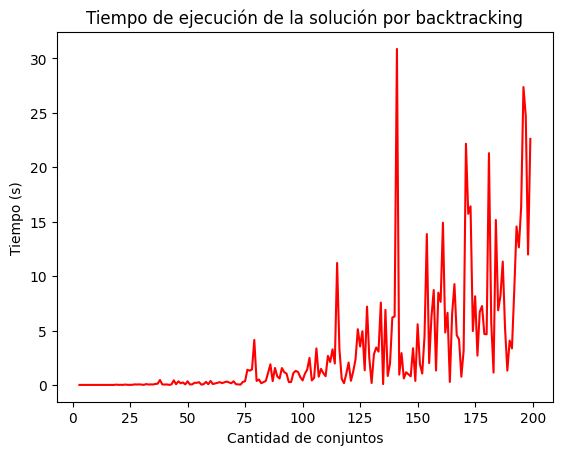

In [ ]:
plt.plot(lengths, bt_time, label='linealp', color='red')
plt.title('Tiempo de ejecución de la solución por backtracking')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')


Text(0.5, 0, 'Cantidad de conjuntos')

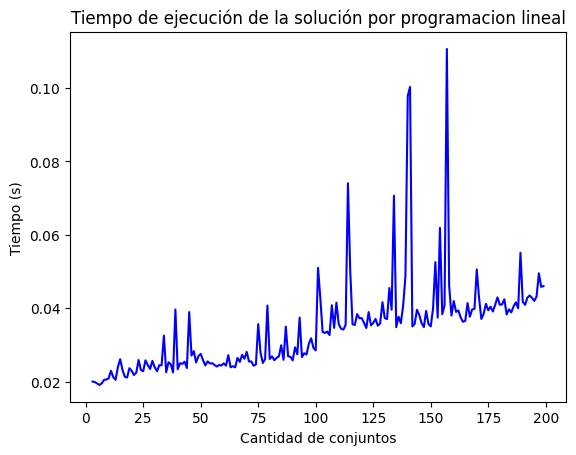

In [ ]:
plt.plot(lengths, lp_time, label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')

Text(0.5, 0, 'Cantidad de conjuntos')

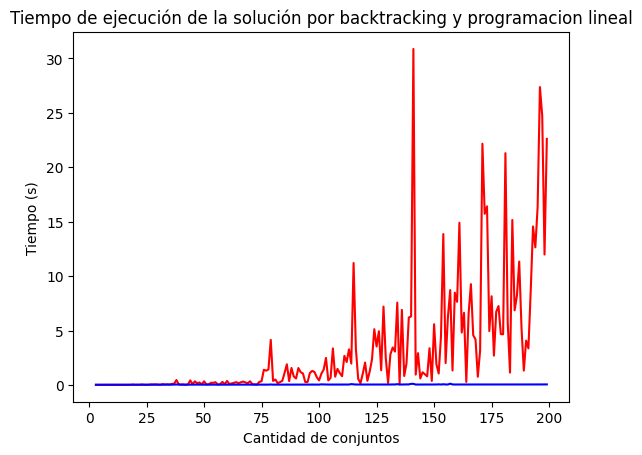

In [ ]:
plt.plot(lengths, bt_time, label='backtracking', color='red')
plt.plot(lengths, lp_time, label='linealp', color='blue')
plt.title('Tiempo de ejecución de la solución por backtracking y programacion lineal')
plt.ylabel('Tiempo (s)')
plt.xlabel('Cantidad de conjuntos')